# Deteccão de COVID-19 em imagens de raio-X

O objetivo deste exercicio é desenvolver um classificador capaz de detectar a presença de COVID-19 em imagens de raio-X

As métricas escolhidas são F1 e Equal Error Rate (ERR)

Note que uma das dificuldades deste exercicio será em processar as imagens, que são de 1100 x 1100 pixels.

## Importação das bibliotecas

In [ ]:
! pip install neptune-client==0.9.1

     |████████████████████████████████| 215kB 24.6MB/s 
     |████████████████████████████████| 829kB 41.4MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 174kB 48.2MB/s 
     |████████████████████████████████| 133kB 46.9MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=014c0aa8028c696ae4609f0c13b8fffc54eb0cbf1e40d11cab1f6637b6f8f930
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=511f04e304b80a8fc87d126b61fa3455e61ca30b81adad372884db8f8075d3d6
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

In [ ]:
!pip install pyeer

     |████████████████████████████████| 614kB 28.1MB/s 
  Created wheel for pyeer: filename=pyeer-0.5.4-cp37-none-any.whl size=603835 sha256=a08d92e6a07c2b0f24403112f882972e1c72ddb096592613854f351a69fe9649
  Stored in directory: /root/.cache/pip/wheels/8c/26/2e/39ca25f59deb5f470fbb378f70b79033719582d9c894e9803f
Successfully built pyeer


In [ ]:
import h5py
from torchvision import transforms
from sklearn.metrics import f1_score
from pyeer.eer_info import get_eer_stats,plot_eer_stats

import matplotlib.pyplot as plt
import neptune.new as neptune

## Dataset e dataloader

### Carregamento, criação dataset e do dataloader

In [ ]:
# O download demora.
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test2.hdf5 .

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test2.hdf5...
| [1/1 files][  1.1 GiB/  1.1 GiB] 100% Done  60.0 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.1 GiB.                                      


In [ ]:
h5file_teste2 = h5py.File('./test2.hdf5', 'r')
images = h5file_teste2['data'][:]
labels = h5file_teste2['label'][:]

In [ ]:
print(images.shape)
print(labels.shape)

(1000, 1100, 1100)
(1000,)


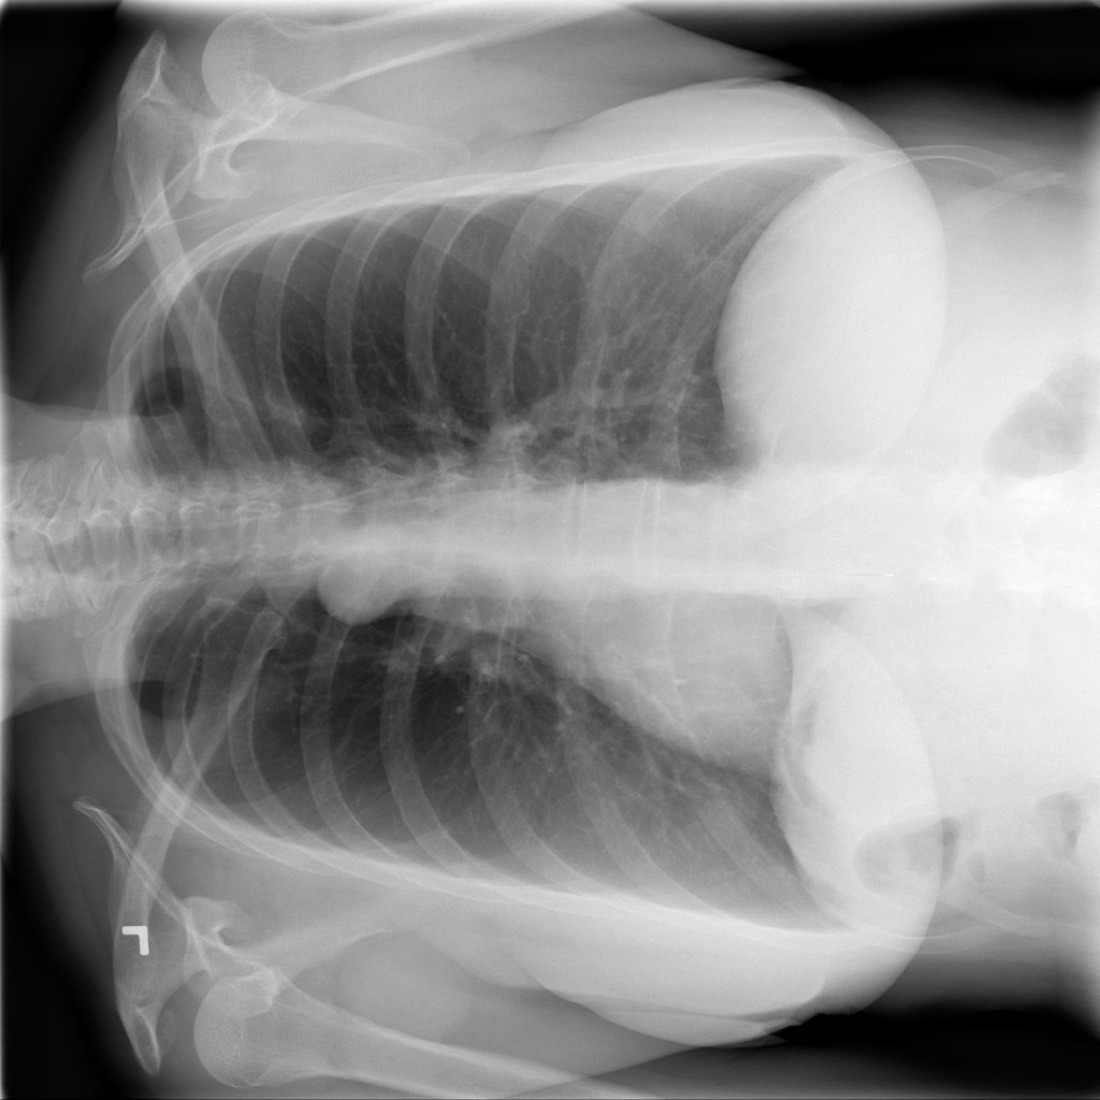

In [ ]:
transforms.ToPILImage()(images[labels==0][0])

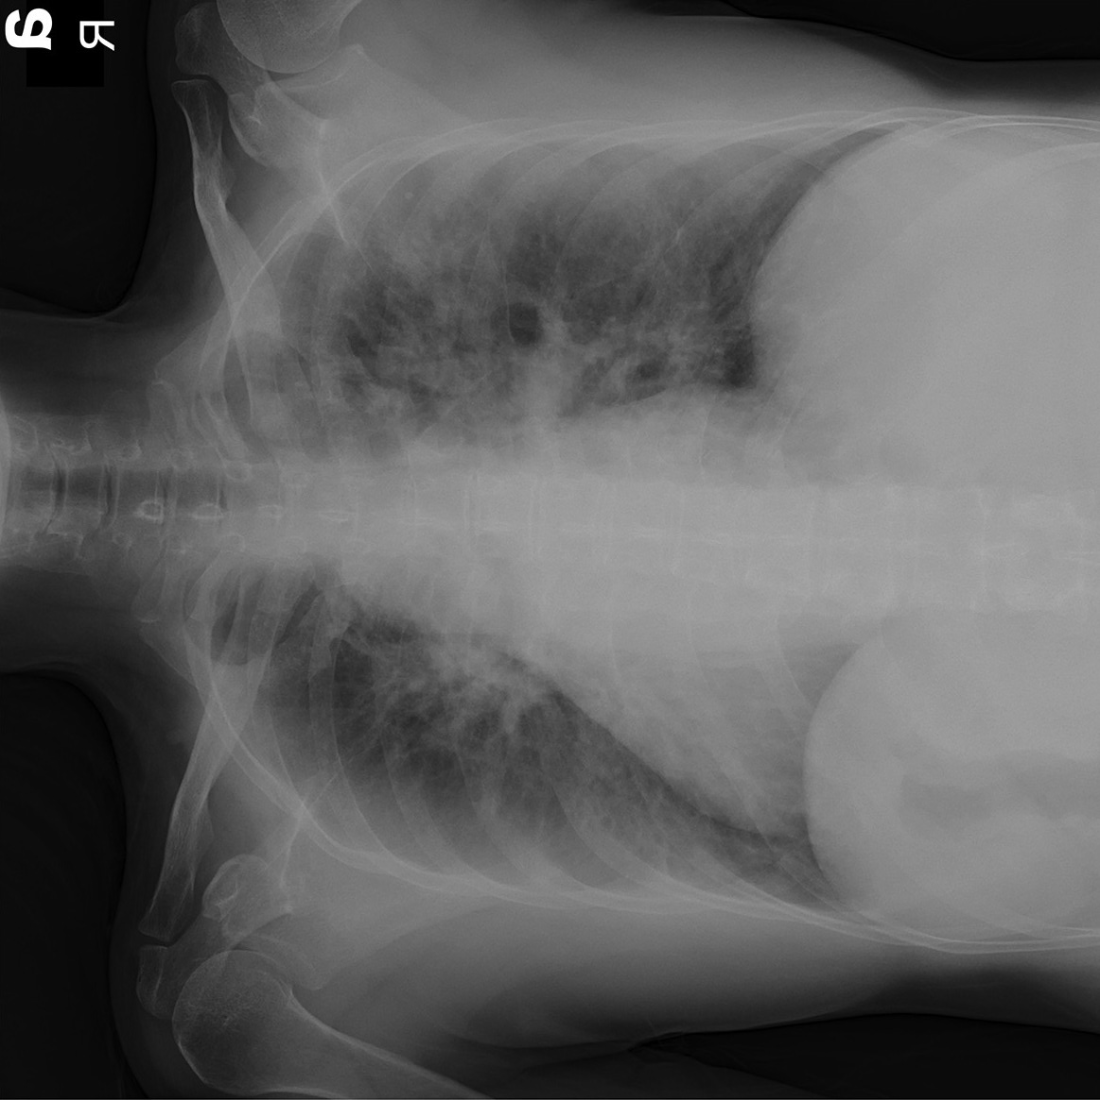

In [ ]:
img = images[labels==1][0]
img = transforms.ToTensor()(img)
transforms.ToPILImage()(img)

In [ ]:
print(images[labels==0].mean())
print(images[labels==1].mean())

129.24440997736139
134.53714093179548


#Código para treinamento da rede e inferêência de resultados para treino, validação e teste 1, do notebook anterior.

In [ ]:
!pip install pytorch_lightning==1.2.10

     |████████████████████████████████| 849kB 33.3MB/s 
     |████████████████████████████████| 112kB 56.9MB/s 
     |████████████████████████████████| 184kB 49.1MB/s 
     |████████████████████████████████| 276kB 47.2MB/s 
     |████████████████████████████████| 1.3MB 43.3MB/s 
     |████████████████████████████████| 296kB 50.8MB/s 
     |████████████████████████████████| 143kB 55.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=7815c8ad29c952304376bb309d67e322e928af1b28bc1cb7b4facc7358aa318f
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import cv2
from collections import OrderedDict
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision

import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer
from PIL import Image

pytorch_lightning.utilities.seed.seed_everything(seed=123)

Global seed set to 123


123

## Dataset e dataloader

### Carregamento, criação dataset e do dataloader

In [ ]:
# O download demora.
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/* .

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test.hdf5...
Skipping existing item: file://./test2.hdf5
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/train.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/valid.hdf5...


In [ ]:
size_final = (224, 224)

path = 'train'
path_dir = './' + path +'.hdf5'
h5file = h5py.File(path_dir, 'r')
imagem = (np.uint8(h5file['data'][0]))
imagem = cv2.resize( imagem ,size_final,interpolation=cv2.INTER_CUBIC)
np.save('image_teste', imagem) 


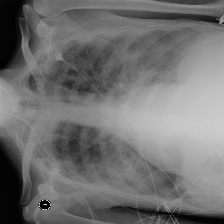

In [ ]:
image_load_test = np.load('image_teste.npy')
transforms.ToPILImage()(image_load_test)

In [ ]:
paths = ['train','valid','test','test2']
for path in paths:
  !mkdir $path
  %cd $path
  !mkdir 0
  !mkdir 1
  %cd ..
  !pwd

/content/train
/content
/content
/content/valid
/content
/content
/content/test
/content
/content
/content/test2
/content
/content


In [ ]:
paths = ['train','valid','test','test2']
for path in paths:
  path_dir = './' + path +'.hdf5'
  h5file = h5py.File(path_dir, 'r')
  for i in range(len(h5file['data'])):
      imagem = (np.uint8(h5file['data'][i]))
      imagem = cv2.resize( imagem ,size_final,interpolation=cv2.INTER_CUBIC)
      im = Image.fromarray(imagem)
      im.save(path+'/'+str(h5file['label'][i])+'/imagem'+str(i)+'.jpg')

In [ ]:
!rm test.hdf5 train.hdf5 valid.hdf5 test2.hdf5

Aqui criamos um dataset sem aumento de dados

In [ ]:
size_final = (224, 224)

transform_train = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=size_final)])

transform_valid = transform_train

In [ ]:
rootdir = '/content'
train_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/train/', transform=transform_train)

val_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/valid/', transform=transform_valid)

test_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/test/', transform=transform_valid)

test_dataset2 = torchvision.datasets.ImageFolder(
    rootdir + '/test2/', transform=transform_valid)

In [ ]:
# class Hdf5_Dataset(torch.utils.data.Dataset):

#     def __init__(self, path, transform):

#         h5file = h5py.File(path, 'r')
#         # Hack para deixar mais rapido o carregamento das imagens.
#         self.images = h5file['data'][:1000]
#         self.labels = h5file['label'][:1000]
#         self.transform = transform

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         label = self.labels[idx].astype(np.int64)
#         img = self.images[idx].astype(np.uint8)
#         img = self.transform(img)
#         img = img.tile(3, 1, 1)
      
#         return img, label

In [ ]:
# train_dataset = Hdf5_Dataset('./train.hdf5', transform=transform_train)
# val_dataset = Hdf5_Dataset('./valid.hdf5', transform=transform_valid)
# test_dataset = Hdf5_Dataset('./test.hdf5', transform=transform_valid)

In [ ]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)


print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))
print('Número de minibatches de teste:', len(test_dataloader2))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 60
Número de minibatches de validação: 20
Número de minibatches de teste: 20
Número de minibatches de teste: 20

Dimensões dos dados de um minibatch: torch.Size([50, 3, 224, 224])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


In [ ]:
class MyLightningModule(LightningModule):
    def __init__(self, hparams, run):
        super().__init__()

        print(hparams)
        self.hparams = hparams
        run['hparams'] = hparams  # Log to Neptune.
        self.criterion = nn.CrossEntropyLoss(reduction='none')

        # Carregando um modelo baseado na MobileNet V3.
        self.model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=hparams['pretrained'])
        # Modificando a ultima camada de classificação para 2 classes.
        self.model.fc.out_features=2

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch

        # predict da rede
        logits = self.model(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        loss = batch_losses.mean()
        run['train/batch_loss'].log(loss)

        # O PL sempre espera um retorno nomeado 'loss' da training_step.
        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)

        self.log('valid_loss', avg_loss.item(), prog_bar=True)
        self.log('valid_accuracy', accuracy.item(), prog_bar=True)
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)

        self.log('test_loss', avg_loss.item())
        self.log('test_accuracy', accuracy.item())

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'])
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

In [ ]:
def verify(pl_model,dataloader):
  pl_model.model.eval()
  y_true = []
  y_pred = []
  y_score = []

  newlist = []
  for x,y in iter(dataloader):
    x, y = x.cuda(), y.cuda()
    with torch.no_grad():
      logit = pl_model.model(x)
      pred = torch.argmax(logit,dim=1)
    # y_true_total = np.append(y_true_total,np.array(y.cpu()))
    # y_pred_total = np.append(y_pred_total,np.array(y_pred.cpu()))
    # y_score_total = np.append(y_score_total,np.array(logit.cpu()))
    y_true.append(y.cpu())
    y_pred.append(pred.cpu())
    y_score.append(logit.cpu())

  y_true = np.concatenate(y_true)
  y_pred = np.concatenate(y_pred)
  y_score = np.concatenate(y_score)


    # y_true_total.append(np.array(y.cpu()))
    # y_pred_total.append(np.array(y_pred.cpu()))

  print(f1_score(y_true, y_pred, average='macro'))
  print(f1_score(y_true, y_pred, average='micro'))

  # Porção de código com auxílio de Marcos Piau
  print(y_score.shape)
  y_probs = torch.softmax(torch.Tensor(y_score), dim=1).numpy()
  y_probs = y_probs[:,1]

  gen_scores = y_probs[y_true == 1]
  imp_scores = y_probs[y_true == 0]
  eer_stats = get_eer_stats(gen_scores = gen_scores, imp_scores = imp_scores)
  
  print(f'EER: {eer_stats.eer:.4f}')
  print(f'EER Threshold: {eer_stats.eer_th:.4f}')

  plot_eer_stats([eer_stats], ['test'])

# Sem Aumentação de Dados

In [ ]:
hparams = {
    'max_epochs': 100,
    'learning_rate': 3e-4,
    'pretrained': True,
    'augmentation': False
}

run = neptune.init(project='d230640/Aula7', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZTg1OGU3Yi1jOWE1LTRjMjEtYTJjNS1hMjMwM2Y3NDRjOTUifQ==')
run["sys/tags"].add([f'pre:{hparams["pretrained"]}', f'aug:{hparams["augmentation"]}'])

pl_model = MyLightningModule(hparams=hparams, run=run)
trainer = Trainer(max_epochs=hparams['max_epochs'], gpus=1,num_sanity_val_steps=0)
trainer.fit(pl_model, train_dataloader, val_dataloader)

https://app.neptune.ai/d230640/Aula7/e/AUL2-17
{'max_epochs': 100, 'learning_rate': 0.0003, 'pretrained': True, 'augmentation': False}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 25.6 M
-----------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)


1

In [ ]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9690000414848328, 'test_loss': 0.214941143989563}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.9690000414848328, 'test_loss': 0.214941143989563}]

In [ ]:
trainer.test(pl_model, test_dataloader2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9660000205039978, 'test_loss': 0.20446717739105225}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.9660000205039978, 'test_loss': 0.20446717739105225}]

# Verificação das métricas F1 e Equal Error Rate (ERR) - Sem Aumentação da Dados

In [ ]:
verify(pl_model,train_dataloader)

0.9996552902886657
0.9996666666666667
(3000, 1000)
EER: 0.0000
EER Threshold: 0.5517


In [ ]:
verify(pl_model,val_dataloader)

0.9685882293813137
0.97
(1000, 1000)
EER: 0.0391
EER Threshold: 0.0012


In [ ]:
verify(pl_model,test_dataloader)

0.9684070315756432
0.969
(1000, 1000)
EER: 0.0360
EER Threshold: 0.0047


In [ ]:
verify(pl_model,test_dataloader2)

0.8789587605377079
0.966
(1000, 1000)
EER: 0.0764
EER Threshold: 0.0002


#Com Aumentação de Dados

In [ ]:
size_large = (256, 256)
size_final = (224, 224)

transform_train = transforms.Compose([
    transforms.Resize(size=size_large),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(3, translate=None, scale=(0.95, 1.05), shear=None, resample=False, fillcolor=2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=size_final),
    transforms.ToTensor()])

# Não funciona se fizermos train_dataloader.dataset.transform, portanto temos que recriar o Dataset e Dataloader.
train_dataset = torchvision.datasets.ImageFolder(
    rootdir + '/train/', transform=transform_train)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1329: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


In [ ]:
hparams = {
    'max_epochs': 100,
    'learning_rate': 3e-4,
    'pretrained': True,
    'augmentation': True
}
run = neptune.init(project='d230640/Aula7', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmZTg1OGU3Yi1jOWE1LTRjMjEtYTJjNS1hMjMwM2Y3NDRjOTUifQ==')
run["sys/tags"].add([f'pre:{hparams["pretrained"]}', f'aug:{hparams["augmentation"]}'])

pl_model = MyLightningModule(hparams=hparams, run=run)
trainer = Trainer(max_epochs=hparams['max_epochs'], gpus=1,num_sanity_val_steps=0)
trainer.fit(pl_model, train_dataloader, val_dataloader)

https://app.neptune.ai/d230640/Aula7/e/AUL2-19
{'max_epochs': 100, 'learning_rate': 0.0003, 'pretrained': True, 'augmentation': True}


Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 25.6 M
-----------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.228   Total estimated model params size (MB)


1

In [ ]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.956000030040741, 'test_loss': 0.18612739443778992}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.956000030040741, 'test_loss': 0.18612739443778992}]

In [ ]:
trainer.test(pl_model, test_dataloader2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9450000524520874, 'test_loss': 0.35175782442092896}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.9450000524520874, 'test_loss': 0.35175782442092896}]

# Verificação das métricas F1 e Equal Error Rate (EER) - Com Aumentação da Dados

In [ ]:
verify(pl_model,train_dataloader)

0.978152105044679
0.979
(3000, 1000)
EER: 0.0293
EER Threshold: 0.1334


In [ ]:
verify(pl_model,val_dataloader)

0.9675267197482587
0.969
(1000, 1000)
EER: 0.0391
EER Threshold: 0.1079


In [ ]:
verify(pl_model,test_dataloader)

0.9551203590371278
0.956
(1000, 1000)
EER: 0.0561
EER Threshold: 0.1076


In [ ]:
verify(pl_model,test_dataloader2)

0.784508935043157
0.945
(1000, 1000)
EER: 0.1534
EER Threshold: 0.0001
